# De novo design

### Developers: Mat Bieniek, Ben Cree, Rachael Pirie, Josh Horton

* Add R-groups in user-defined positions
* Output ADMET properties
* Perform constrained optimisation
* Score poses
* Send output to free energy calculations

Open source, customisable, fast/easy to use.

In [1]:
import copy
import glob
import prody
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd
from rgroup import RMol, RList, build_molecules, fix_receptor, optimise_in_receptor, RGroups, sort_conformers, ic50

<frozen importlib._bootstrap>:228: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.


In [2]:
%cd ~/rgroups/dat/ptp1b/19jan

/home/c0065492/rgroups/dat/ptp1b/19jan


In [3]:
prefix = 'lig_' #to extract experimental data from ligands.yml

In [4]:
!wget -nc https://files.rcsb.org/download/2QBS.pdb
pdb = '2QBS.pdb'

File ‘2QBS.pdb’ already there; not retrieving.



In [5]:
RMol.set_gnina(loc='/home/c0065492/software/gnina')

In [6]:
# load the complex with the ligand
sys = prody.parsePDB(pdb)


rec = sys.select('not (nucleic or hetatm) and not water')
#mol = sys.select('resname 19H and chain A')
mol = sys.select('resname 0X5')

prody.writePDB('rec.pdb', rec)
#prody.writePDB('lig.pdb', mol)

@> 2676 atoms and 1 coordinate set(s) were parsed in 0.04s.


'rec.pdb'

In [7]:
#!wget 'https://models.rcsb.org/v1/5nev/ligand?auth_seq_id=301&label_asym_id=E&encoding=sdf&filename=5nev_E_72L.sdf' -O lig.sdf

!obabel -isdf core.sdf -osdf -O coreh.sdf -p 7
# ^manually modify the files if need be
%pwd

*** Open Babel Warning  in ReadMolecule
  Failed to kekulize aromatic bonds in MOL file (title is 2QBS)

1 molecule converted


'/home/c0065492/rgroups/dat/ptp1b/19jan'

In [8]:
# load the ligand
# rdkit doesn't do a good job with protonation, 
#init_mol = Chem.MolFromPDBFile('lig.pdb', removeHs=False)
#init_mol = Chem.AddHs(init_mol, addCoords=True)

init_mol = Chem.SDMolSupplier('coreh.sdf', removeHs=False)[0]

# get the R group representation of the rdkit Mol
rinit_mol = RMol(init_mol)

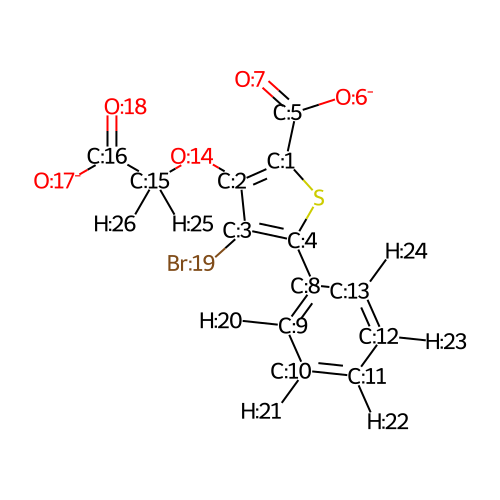

In [9]:
# select the atom to be replaced with the R group
rinit_mol.rep2D(idx=True, size=(500, 500))

In [10]:
#remove 44 since all conformers clash with protein
ligand_ids = ['20667_2qbp','20669_2qbr','20670_2qbs','23330_2qbq','23466','23468','23469','23470','23471','23472',\
              '23473','23474','23475','23476','23477','23479','23480','23482']
# read the rgroups 1 by 1 in a loop
# assumes that there is only one -r.mol in each dir
rgroups = [Chem.MolFromMolFile(glob.glob(f'{ligand_id}/*.mol')[0], removeHs=False) for ligand_id in ligand_ids]
rgroups

In [11]:
# build a list of molecules
attachment_index = [21]
rmols = build_molecules(rinit_mol, attachment_index, rgroups)

Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7f7b5ecd40a0> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7f7b5ecd4100>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7f7b5ecd4c40> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7f7b5ecd4b80>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7f7b5ecd40a0> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7f7b5ecd4100>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7f7b5ecd4b80> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7f7b5ecd4c40>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7f7b5ecd40a0> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7f7b5ecd4100>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7f7b5ecd4b80> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7f7b5ecd4c40>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7f7b5ecd40a0> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7f7b5ecd4100>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom o

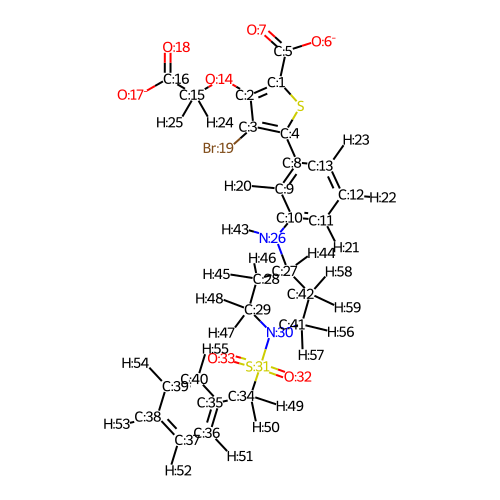

In [12]:
rmols[0].rep2D(idx=True, size=(500, 500))

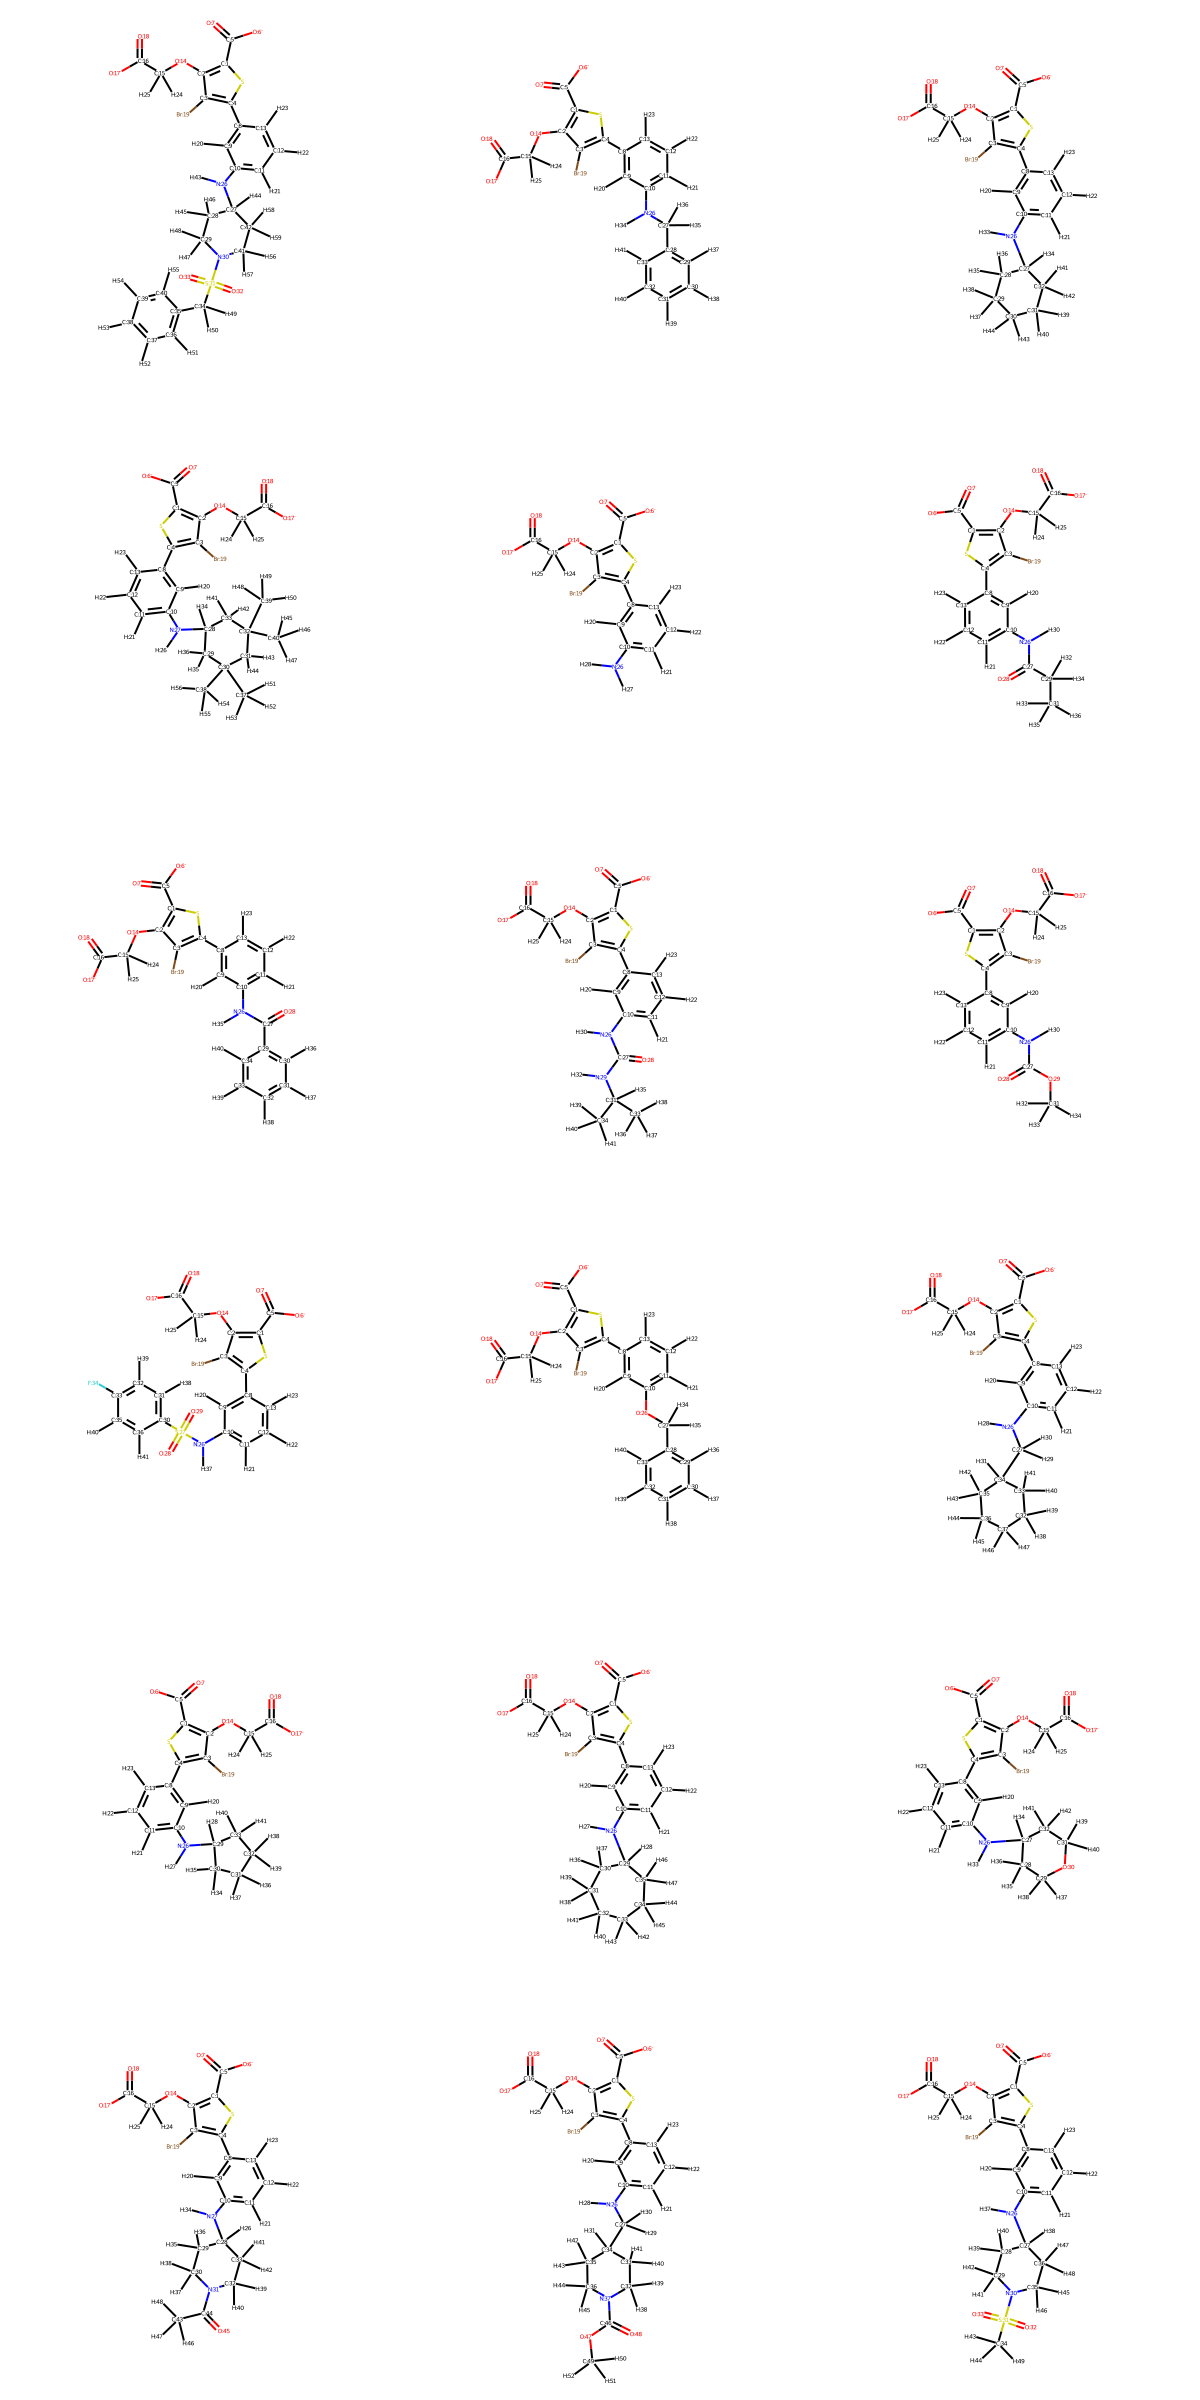

In [13]:
rmols.rep2D()

In [14]:
rmols[3].rep3D()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [15]:
rmols.toxicity()

MW  HBA  HBD    LogP  Pass_Ro5  has_pains  has_unwanted_subs  \
0  606.014102    9    1  2.0761      True      False              False   
0  458.978703    7    1  2.2819      True      False              False   
0  451.010003    7    1  2.4144      True      False              False   
0  507.072603    7    1  3.6866      True      False              False   
0  368.931753    7    1  0.2520      True      False               True   
0  424.957967    7    1  1.0183      True      False              False   
0  472.957967    7    1  1.9221      True      False              False   
0  453.984516    7    2  1.1997      True      False              False   
0  426.937232    8    1  0.8481      True      False              False   
0  526.915531    8    1  1.6097      True      False              False   
0  459.962718    7    0  2.2488      True      False              False   
0  465.025653    7    1  2.6620      True      False              False   
0  436.994353    7    1  2.0243      True      False              False   
0  465.025653    7    1  2.8045      True      False              False   
0  452.989267    8    1  1.2607      True      False              False   
0  494.015817    8    1  1.0926      True      False              False   
0  524.026381    9    1  1.5601      True      False              False   
0  529.982802    9    1  0.5057      True      False              False   

   has_prob_fgs  synthetic_accessibility  
0         False                 6.337247  
0         False                 7.321925  
0         False                 7.720540  
0         False                 7.128524  
0         False                 6.442367  
0         False                 6.897333  
0         False                 6.972823  
0         False                 7.288997  
0         False                 6.597098  
0         False                 6.736687  
0         False                 7.154987  
0         False                 7.914256  
0         False                 7.514903  
0         False                 7.915200  
0         False                 7.504474  
0         False                 7.723592  
0         False                 7.873985  
0         False                 7.718606

In [16]:
rmols.generate_conformers(num_conf=200,
                         minimum_conf_rms=0.5
                         )

RMol index 0
removed 3 duplicated conformations
RMol index 1
removed 188 duplicated conformations
RMol index 2
removed 49 duplicated conformations
RMol index 3
RMol index 4
removed 200 duplicated conformations
RMol index 5
removed 180 duplicated conformations
RMol index 6
removed 184 duplicated conformations
RMol index 7
removed 153 duplicated conformations
RMol index 8
removed 188 duplicated conformations
RMol index 9
removed 181 duplicated conformations
RMol index 10
removed 189 duplicated conformations
RMol index 11
removed 15 duplicated conformations
RMol index 12
removed 111 duplicated conformations
RMol index 13
removed 9 duplicated conformations
RMol index 14
removed 84 duplicated conformations
RMol index 15
removed 16 duplicated conformations
RMol index 16
removed 17 duplicated conformations
RMol index 17
removed 5 duplicated conformations


In [17]:
#rmol.rep3D(template=True)

In [18]:
rmols.GetNumConformers()

[198,
 13,
 152,
 201,
 1,
 21,
 17,
 48,
 13,
 20,
 12,
 186,
 90,
 192,
 117,
 185,
 184,
 196]

### Optimise conformers in context of protein

In [19]:
# fix the receptor file 
fix_receptor("rec.pdb", "rec_h.pdb")
# load back into prody
rec_fix = prody.parsePDB("rec_h.pdb")

@> 4811 atoms and 1 coordinate set(s) were parsed in 0.05s.


In [20]:
# filter by the protein clashes
rmols[2].rep3D(prody=rec_fix)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [21]:
rmols.removeConfsClashingWithProdyProt(rec_fix)

RMol index 0
Clash with the protein. Removing conformer id: 197
Clash with the protein. Removing conformer id: 196
Clash with the protein. Removing conformer id: 195
Clash with the protein. Removing conformer id: 194
Clash with the protein. Removing conformer id: 193
Clash with the protein. Removing conformer id: 192
Clash with the protein. Removing conformer id: 191
Clash with the protein. Removing conformer id: 189
Clash with the protein. Removing conformer id: 187
Clash with the protein. Removing conformer id: 185
Clash with the protein. Removing conformer id: 183
Clash with the protein. Removing conformer id: 182
Clash with the protein. Removing conformer id: 177
Clash with the protein. Removing conformer id: 176
Clash with the protein. Removing conformer id: 174
Clash with the protein. Removing conformer id: 173
Clash with the protein. Removing conformer id: 171
Clash with the protein. Removing conformer id: 170
Clash with the protein. Removing conformer id: 167
Clash with the pro

In [22]:
rmols.GetNumConformers()

[72, 4, 79, 59, 1, 18, 9, 18, 10, 8, 3, 47, 46, 78, 61, 69, 45, 73]

In [23]:
rmols[0].rep3D(prody=rec_fix)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [24]:
# opt_mol, energies
energies = rmols.optimise_in_receptor(
    receptor_file="rec_h.pdb", 
    ligand_force_field="openff", 
    use_ani=True,
    sigma_scale_factor=0.8,
    relative_permittivity=4
)

RMol index 0


Optimising conformer: 100%|█████████████████████| 72/72 [07:09<00:00,  5.97s/it]


RMol index 1


Optimising conformer: 100%|███████████████████████| 4/4 [00:31<00:00,  7.86s/it]


RMol index 2


Optimising conformer: 100%|█████████████████████| 79/79 [06:41<00:00,  5.08s/it]


RMol index 3


Optimising conformer: 100%|█████████████████████| 59/59 [05:42<00:00,  5.80s/it]


RMol index 4


Optimising conformer: 100%|███████████████████████| 1/1 [00:06<00:00,  6.29s/it]


RMol index 5


Optimising conformer: 100%|█████████████████████| 18/18 [01:19<00:00,  4.43s/it]


RMol index 6


Optimising conformer: 100%|███████████████████████| 9/9 [00:38<00:00,  4.24s/it]


RMol index 7


Optimising conformer: 100%|█████████████████████| 18/18 [01:46<00:00,  5.90s/it]


RMol index 8


Optimising conformer: 100%|█████████████████████| 10/10 [00:47<00:00,  4.77s/it]


RMol index 9


Optimising conformer: 100%|███████████████████████| 8/8 [00:51<00:00,  6.46s/it]


RMol index 10


Optimising conformer: 100%|███████████████████████| 3/3 [00:06<00:00,  2.29s/it]


RMol index 11


Optimising conformer: 100%|█████████████████████| 47/47 [02:04<00:00,  2.64s/it]


RMol index 12


Optimising conformer: 100%|█████████████████████| 46/46 [02:31<00:00,  3.30s/it]


RMol index 13


Optimising conformer: 100%|█████████████████████| 78/78 [03:34<00:00,  2.75s/it]


RMol index 14


Optimising conformer: 100%|█████████████████████| 61/61 [02:36<00:00,  2.56s/it]


RMol index 15


Optimising conformer: 100%|█████████████████████| 69/69 [02:44<00:00,  2.38s/it]


RMol index 16


Optimising conformer: 100%|█████████████████████| 45/45 [02:10<00:00,  2.90s/it]


RMol index 17


Optimising conformer: 100%|█████████████████████| 73/73 [02:22<00:00,  1.95s/it]


In [25]:
rmols[0].rep3D()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [26]:
for i in range(len(ligand_ids)):
    rmols[i].to_file("optimised_coords_" + str(ligand_ids[i]) + ".pdb")

In [27]:
final_energies = rmols.sort_conformers(energy_range=5)

RMol index 0
RMol index 1
RMol index 2
RMol index 3
RMol index 4
RMol index 5
RMol index 6
RMol index 7
RMol index 8
RMol index 9
RMol index 10
RMol index 11
RMol index 12
RMol index 13
RMol index 14
RMol index 15
RMol index 16
RMol index 17


In [28]:
for i in range(len(ligand_ids)):
    rmols[i].to_file("best_conformers_" + str(ligand_ids[i]) + ".pdb")

In [29]:
#RMol.set_gnina(loc='gnina')

In [30]:
CNNscores = rmols.gnina(receptor_file="rec_h.pdb") 

RMol index 0
RMol index 1
RMol index 2
RMol index 3
RMol index 4
RMol index 5
RMol index 6
RMol index 7
RMol index 8
RMol index 9
RMol index 10
RMol index 11
RMol index 12
RMol index 13
RMol index 14
RMol index 15
RMol index 16
RMol index 17


In [31]:
ic50_scores = []
for i in range(len(CNNscores)):
    ic50_scores.append([ic50(x) for x in CNNscores[i]])

In [32]:
for i in range(len(ic50_scores)):
    with open('scores_' + str(ligand_ids[i]) + '.dat', 'w') as f:
        for x in range(len(ic50_scores[i])):
            f.write(str(ic50_scores[i][x])+'\n')

In [33]:
lowest = []
for i in range(len(ic50_scores)):
    try:
        lowest.append(ic50_scores[i][0])
    except:
        pass

In [34]:
import yaml
with open("ligands.yml", "r") as stream:
    try:
        data = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
suffix = ''
experimental = []
for i in range(len(ligand_ids)):
    if data[prefix + str(ligand_ids[i])+suffix]['measurement']['unit'] == 'nM':
        print('found nM')
        experimental.append(data[prefix+ str(ligand_ids[i])+suffix]['measurement']['value'])
    elif data[prefix + str(ligand_ids[i])]['measurement']['unit'] == 'uM':
        experimental.append(1000*data[prefix+ str(ligand_ids[i])+suffix]['measurement']['value'])
    else:
        print('UNKNOWN UNIT - SKIPPING')
experimental 

[4.0,
 470.0,
 210.0,
 36.0,
 1700.0,
 2000.0,
 2100.0,
 2100.0,
 2000.0,
 440.0,
 680.0,
 200.0,
 390.0,
 120.0,
 310.0,
 190.0,
 390.0,
 44.0]

In [35]:
import pandas as pd
#rmol that has no conformers causes issues, potential fix is look for None in final_energies/CNNscore and delete that element from all of the following so theyre the same size & can be plotted?
name = [ligand_ids[i:i+1] for i in range(0, len(ligand_ids), 1)]
energies = [i[0] for i in final_energies]
cnn = [i[0] for i in CNNscores]
ic50 = [i[0] for i in ic50_scores]
expt = [i for i in experimental]
output = pd.DataFrame({'ID' : name, 'Final energies' : energies, 'Gnina score' : cnn, 'Gnina IC50 / nM' : ic50, 'Experimental IC50 / nM' : expt})
output

ID  Final energies  Gnina score  Gnina IC50 / nM  \
0   [20667_2qbp]             0.0      6.30436       496.180851   
1   [20669_2qbr]             0.0      5.83778      1452.847398   
2   [20670_2qbs]             0.0      6.23468       582.532285   
3   [23330_2qbq]             0.0      6.41318       386.206875   
4        [23466]             0.0      5.45793      3483.934649   
5        [23468]             0.0      5.62560      2368.099794   
6        [23469]             0.0      5.92522      1187.900322   
7        [23470]             0.0      5.90861      1234.212669   
8        [23471]             0.0      5.63786      2302.183834   
9        [23472]             0.0      5.76961      1699.769374   
10       [23473]             0.0      5.72309      1891.951504   
11       [23474]             0.0      6.26056       548.832726   
12       [23475]             0.0      5.91464      1217.194552   
13       [23476]             0.0      6.27018       536.809261   
14       [23477]             0.0      6.07656       838.378244   
15       [23479]             0.0      6.29069       512.047205   
16       [23480]             0.0      6.44625       357.890360   
17       [23482]             0.0      6.40353       394.884421   

    Experimental IC50 / nM  
0                      4.0  
1                    470.0  
2                    210.0  
3                     36.0  
4                   1700.0  
5                   2000.0  
6                   2100.0  
7                   2100.0  
8                   2000.0  
9                    440.0  
10                   680.0  
11                   200.0  
12                   390.0  
13                   120.0  
14                   310.0  
15                   190.0  
16                   390.0  
17                    44.0

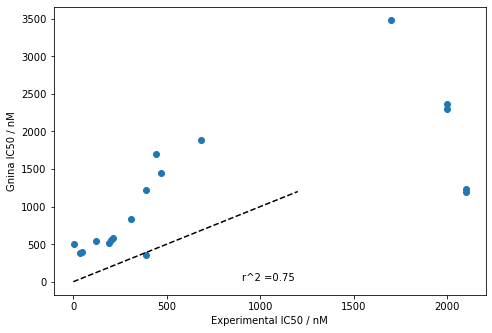

'0.75'

In [36]:
import matplotlib.pyplot as plt
import numpy as np

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(experimental, lowest) #, color='black', marker='x')
ax.set_xlabel('Experimental IC50 / nM')
ax.set_ylabel('Gnina IC50 / nM')

x = np.linspace(0,1200,25)
y = np.linspace(0,1200,25)
ax.plot(x, x, color='black', linestyle='--')

m, cf = np.polyfit(experimental,lowest,1)
m = "{:.2f}".format(m)
r = "r^2 =" + str(m)
#poly1d_fn = np.poly1d(coef) 
plt.savefig('out.png', bbox_inches='tight')
plt.annotate(r, (900,10))
plt.show()
m

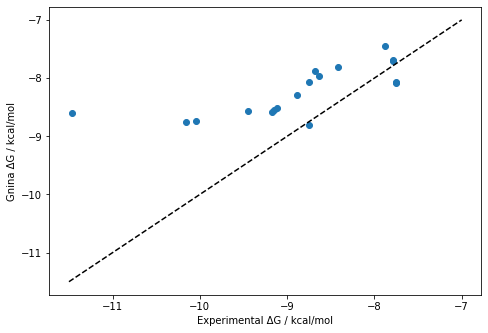

In [37]:
# convert nM to M
lowestinM = [ i * 1e-9 for i in lowest]
exptinM = [ i * 1e-9 for i in expt]

RT = 0.593 # kcal/mol

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])

# DG = RTln(K)
ax.scatter(RT*np.log(exptinM), RT*np.log(lowestinM)) #, color='black', marker='x')
ax.set_xlabel('Experimental \u0394G / kcal/mol')
ax.set_ylabel('Gnina \u0394G / kcal/mol')

x = np.linspace(-11.5,-7,10)
ax.plot(x, x, color='black', linestyle='--')
A = np.vstack([experimental, np.ones(len(experimental))]).T
m, c = np.linalg.lstsq(A, lowest, rcond=None)[0]

m = "{:.2f}".format(m)
r = "r^2 =" + str(m)
plt.annotate(r, (-10,-6))
plt.savefig('deltaG2.png', bbox_inches='tight')
plt.show()

In [38]:
%pwd

'/home/c0065492/rgroups/dat/ptp1b/19jan'

In [39]:
import re
smina_affinities = []
with open('smina_scores.dat', 'r') as f:
    for line in f:
        affinity = re.findall(r'Affinity: -?(-\d+.\d+)', str(line))
        try:
            smina_affinities.append(float(affinity[0]))
        except:
            pass

In [40]:
import matplotlib.pyplot as plt
import numpy as np

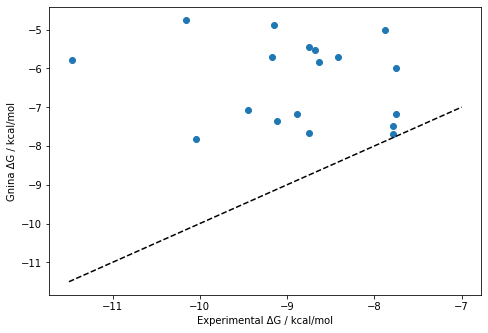

In [41]:
# convert nM to M

exptinM = [ i * 1e-9 for i in experimental]

RT = 0.593 # kcal/mol

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])

# DG = RTln(K)
ax.scatter(RT*np.log(exptinM), smina_affinities) #, color='black', marker='x')
ax.set_xlabel('Experimental \u0394G / kcal/mol')
ax.set_ylabel('Gnina \u0394G / kcal/mol')

x = np.linspace(-11.5,-7,10)
ax.plot(x, x, color='black', linestyle='--')
A = np.vstack([experimental, np.ones(len(experimental))]).T
#m, c = np.linalg.lstsq(A, lowest, rcond=None)[0]

#m = "{:.2f}".format(m)
#r = "r^2 =" + str(m)
#plt.annotate(r, (-10,-6))
plt.savefig('deltaG2.png', bbox_inches='tight')
plt.show()

In [3]:
import dill
dill.load_session('notebook_ptp1b_19jan.db')
%pwd

'/home/c0065492/rgroups/dat/ptp1b/19jan'

In [4]:
CNNscores

[[6.30436, 6.29152, 6.2924, 6.67841, 6.6743],
 [5.83778, 5.83151],
 [6.23468,
  6.23467,
  6.23467,
  6.23467,
  6.23464,
  5.8333,
  5.83329,
  6.0724,
  6.0724,
  6.07278,
  5.94047,
  5.94034,
  5.94023,
  5.94016,
  5.94012,
  5.9401,
  5.7521,
  5.75208,
  5.75208,
  5.76614,
  5.76615,
  5.76616,
  5.76617,
  5.76617,
  5.76617,
  5.76618],
 [6.41318,
  6.41281,
  6.41308,
  6.4133,
  6.41168,
  6.28271,
  6.27871,
  6.27856,
  6.27852,
  6.27843,
  6.27843,
  6.27841,
  6.27837,
  6.49475,
  6.21709,
  6.32645,
  6.29179,
  6.33209,
  6.49029,
  6.55604,
  6.55605,
  6.55603,
  6.55602,
  6.57028,
  6.57036,
  6.57025,
  6.19803,
  6.37056,
  6.37045,
  6.37044,
  6.37043,
  6.37044],
 [5.45793],
 [5.6256,
  5.6256,
  5.62561,
  5.7997,
  5.6204,
  5.62041,
  5.67331,
  5.67332,
  5.67332,
  5.67332,
  5.67332,
  5.67332,
  5.70434,
  5.65223,
  5.65224,
  5.65224,
  5.56607,
  5.56607],
 [5.92522, 5.74037, 5.74054, 5.92701, 5.92707],
 [5.90861,
  5.81771,
  5.81769,
  5.81769,
